# Abstract
## In analyzing the King County Housing data, I aim to give recommendations to real estate investors as to which features of a home and which areas within the county will maximize their profits. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer


%matplotlib inline

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

#### I retained features that reflected the overall structure of the home and property along with features which were indicative of areas within King County toward these aims. I chose to concentrate on what I defined as non-starter homes in the price range of 200-500 thousand dollars. Beyond eliminating features  deemed superfluous, I additionally eliminated properties with either extravagant attributes - such as 6 or more bedrooms - or substandard qualities like not having at least 1 full bathroom. 

In [3]:
#drop columns seen as irrelevant 
data.drop(columns = ['id','date','view','lat','long','sqft_living15', 'sqft_lot15', 'yr_built'], inplace=True)

In [4]:
#eliminate properties valued at $200000 or less and luxury homes from data set, 
#luxury homes defined as $500,000 and over 
#dropped 10041 rows
data = data[(data.price < 500000) & (data.price > 200000)]

#eliminate properties with 6 or more bedrooms and 4 or more bathrooms which were outliers in the data
#dropped 110 rows
data = data[(data.bedrooms < 6) & (data.bathrooms < 4)]

#eliminate properties with less than a full bathroom (defined as shower, bathtub, toilet, & sink) as judged
#to be undesirable. 
#dropped 48 rows
data = data[(data.bathrooms >= 1)]

Correlation with target and collinearity of features check:

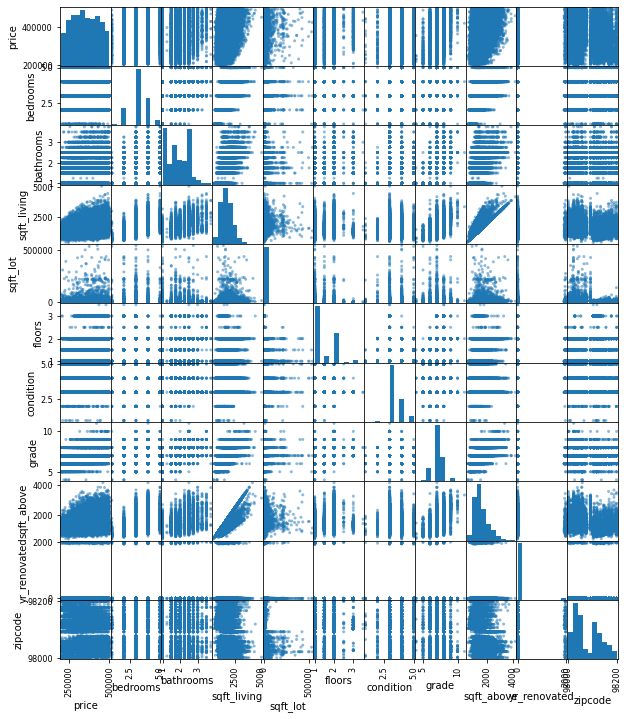

In [5]:
#scatter matrix for data, left out sqft_basement, yr_renovated, and waterfront as will be changing those 
#to binary categoricals
x_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'condition', 'grade','sqft_above', 
          'yr_renovated', 'zipcode']
pd.plotting.scatter_matrix(data[x_cols], figsize=(10,12));

In [6]:
#df to look for collinearity in predictors via correlation matrix pairing
data_pred = data.copy()
data_pred.corr()
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new 
#column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

#list the pairs with a high correlation, indicating collinearity
df[(df.cc > 0.75) & (df.cc < 1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.801744


#### No features appear correlated with the target, price.  Via the scatter matrix and subsequently confirmed by the correlation matrix, the features sqft_above and sqft_living are collinear.  Additionally via the scatter matrix, the following features appear to be categorical: bedrooms, bathrooms, floors, condition, and grade. The features yr_renovated, sqft_basement and waterfront will be turned into binary categorical variables indicating presence of feature at the property. The heat map implies a relation between bedrooms, bathrooms, and sqft_living,  a relation between grade, sqft_above, and yr_built, and possibly a relation between bathrooms and grade, sqft_above, and yr_built.  

In [7]:
#change sqft_basement, yr_renovated, and waterfront to binary categorical variables

#change the value ? to string 0
data['sqft_basement'] = data['sqft_basement'].replace(['?'],'0')
#convert datatype of sqft_basement column to float
data = data.astype({'sqft_basement': float})
#create new boolean column for whether property has a basement
data['has_base'] = np.where((data['sqft_basement'] > 0),1,0)

#fill NaN values in yr_renovated column with 0 indicating no renovations have been done on property
data['yr_renovated'].fillna(0, inplace=True)
#create boolean column for whether a property has been renovated
data['has_renov'] = np.where((data['yr_renovated'] > 0),1,0)

#fill NaN values waterfront column with 0 meaning no waterfront view
data['waterfront'].fillna(0, inplace=True)
#convert waterfront to boolean values
data.waterfront = np.where((data['waterfront'] == 1),1,0)

#drop original columns sqft_basement and yr_renovated
data.drop(columns = ['sqft_basement', 'yr_renovated'], inplace=True)

### First linear regression model - statsmodels only 
#### The predictors yr_renovated, sqft_basement, and waterfront were changed to binary categoricals.  All remaining features were not altered.

In [8]:
#statsmodels regression model with unchanged predictors from scatter matrix 
outcome1 = 'price'
x_cols1 = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 
          'has_base','sqft_above', 'has_renov', 'zipcode']
predictors1 = '+'.join(x_cols1)
formula1 = outcome1 + '~' + predictors1
model = ols(formula=formula1, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     194.6
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:25:00   Log-Likelihood:            -1.4393e+05
No. Observations:               11398   AIC:                         2.879e+05
Df Residuals:                   11385   BIC:                         2.880e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.988e+07   1.35e+06    -14.714      0.000   -2.25e+07   -1.72e+07
bedrooms    -8932.5742   1149.337     -7.772      0.000   -1.12e+04   -6679.676
bathrooms    -326.7708   1725.976     -0.189      0.850   -3709.981    3056.440
sqft_living    27.4175      3.948      6.945      0.000      19.679      35.156
sqft_lot        0.1890      0.026      7.320      0.000       0.138       0.240
floors       1.361e+04   1815.933      7.494      0.000       1e+04    1.72e+04
waterfront   3.751e+04   2.62e+04      1.434      0.152   -1.38e+04    8.88e+04
condition    5500.1178   1177.761      4.670      0.000    3191.503    7808.732
grade        2.637e+04   1203.645     21.911      0.000     2.4e+04    2.87e+04
has_base     1.962e+04   2826.072      6.942      0.000    1.41e+04    2.52e+04
sqft_above      1.1397      4.334      0.263      0.793      -7.356       9.635
has_renov      1.7e+04   4771.483      3.562      0.000    7643.705    2.63e+04
zipcode       203.6381     13.760     14.799      0.000     176.666     230.610
==============================================================================
Omnibus:                     1303.446   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.099
Skew:                           0.185   Prob(JB):                     8.87e-90
Kurtosis:                       2.148   Cond. No.                     1.93e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analysis: first model
Very poor model with a low R squared as well as several high p-values, confidence levels spanning zero, and a positively skewed - or right skewed - distribution in addition to an acceptable kurtosis.

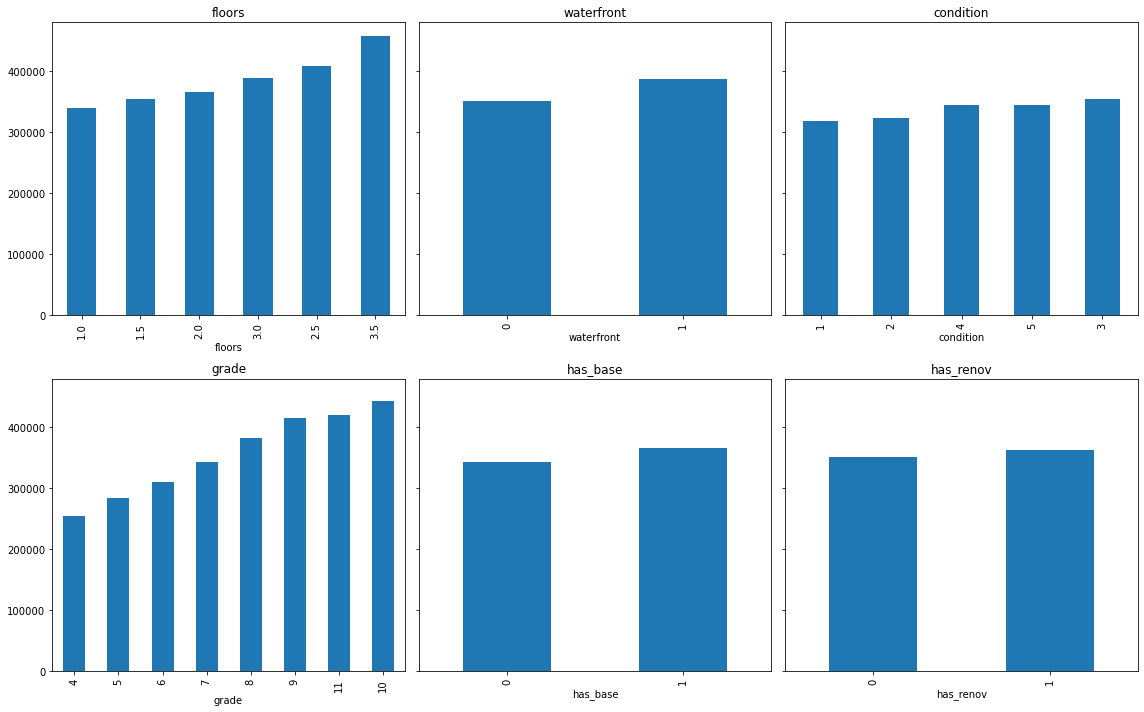

In [9]:
#create bar plots of categoricals: floors, waterfront, condition, grade, has_base, 
#and has_renov
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10), sharey=True)
categoricals = ['floors', 'waterfront', 'condition', 'grade', 'has_base', 'has_renov']

for col, ax in zip(categoricals, axes.flatten()):
    (data.groupby(col)
        .mean()['price']
        .sort_values()
        .plot
        .bar(ax=ax))
    ax.set_title(col)
    
fig.tight_layout();

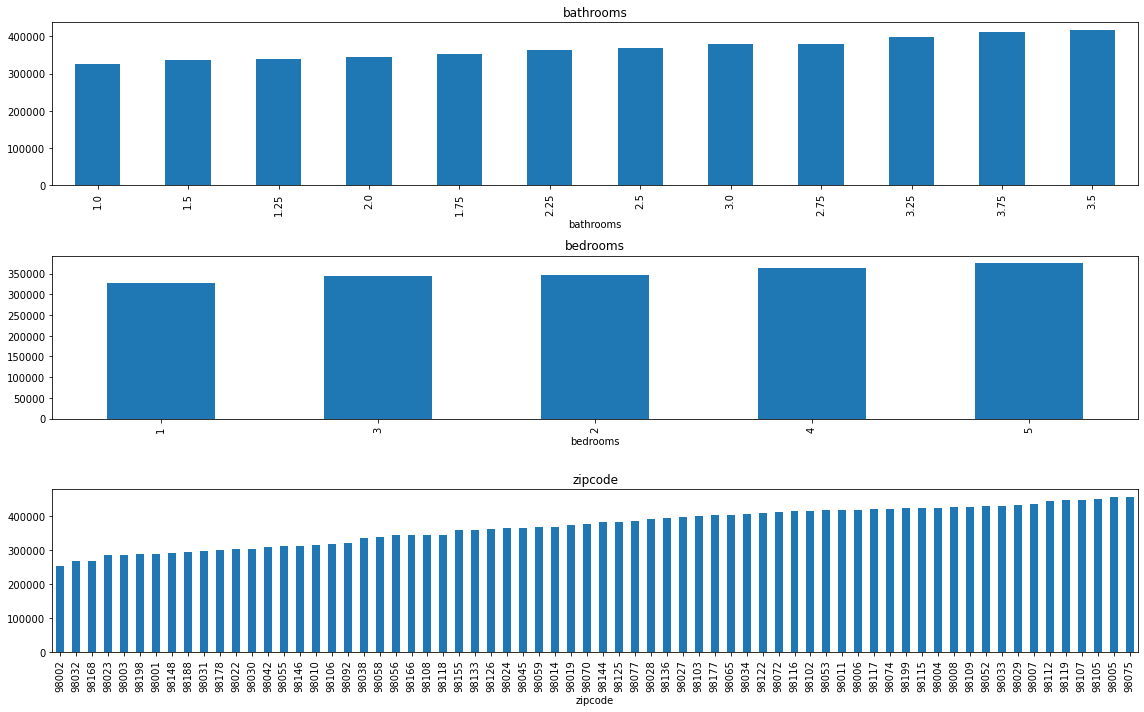

In [10]:
#create bar plots of categoricals: bathrooms, bedrooms, and zipcode
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,10))
categoricals = ['bathrooms', 'bedrooms','zipcode']

for col, ax in zip(categoricals, axes.flatten()):
    (data.groupby(col)
        .mean()['price']
        .sort_values()
        .plot
        .bar(ax=ax))
    ax.set_title(col)
    
fig.tight_layout();

In [11]:
#change values in floors columns to prepare for one hot encoding
def floor(value):
    if value == 1:
        return 1
    elif value == 1.5:
        return '1and_half'
    elif value == 2:
        return 2
    elif value == 2.5:
        return '2and_half'
    elif value == 3:
        return 3
    elif value == 3.5:
        return '3and_half'
       
data.floors = data.floors.apply(floor)

In [12]:
#change values in bathrooms column to prepare for one hot encoding
def baths(value):
    if value == 1:
        return 1
    elif value < 2:
        return '1and_quart_plus'
    elif value == 2:
        return 2
    elif value < 3:
        return '2and_quart_plus'
    elif value == 3:
        return 3
    elif value > 3:
        return '3and_quart_plus'
data.bathrooms = data.bathrooms.apply(baths)

In [13]:
#convert datatype of columns bedrooms, bathrooms, floors, condition, zipcode, and 
#grade to prepare for one hot encoding
convert_dict = {'bedrooms': str, 'bathrooms': str, 'floors': str, 'condition':str, 'zipcode': str, 
                'grade': str}
data = data.astype(convert_dict)

#create dummy variables for categoricals bedrooms, bathrooms, floors, condition, and grade
bedrooms_dum = pd.get_dummies(data['bedrooms'], prefix='bed', drop_first=True)
bathrooms_dum = pd.get_dummies(data['bathrooms'], prefix='bath', drop_first=True)
floors_dum = pd.get_dummies(data['floors'], prefix='fl', drop_first=True)
condition_dum = pd.get_dummies(data['condition'], prefix='cond', drop_first=True)
zip_dum = pd.get_dummies(data['zipcode'], prefix='zip', drop_first=True)
grade_dum = pd.get_dummies(data['grade'], prefix='gr', drop_first=True)

#remove orignial columns of dummy variables, add dummy columns
data = data.drop(['bedrooms', 'bathrooms', 'floors', 'condition', 'zipcode', 'grade'], axis=1)
data = pd.concat([data, bedrooms_dum, bathrooms_dum, floors_dum, condition_dum, zip_dum, grade_dum], axis=1)

In [14]:
#recheck collinearity as have changed features
#df to look for collinearity in predictors via correlation matrix pairing
data_pred = data.copy()
data_pred.corr()
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new 
#column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace = True)
#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)
# rename correlation column as cc rather than 0
df.columns = ['cc']
# drop duplicates
df.drop_duplicates(inplace=True)
#list the pairs with a high correlation, indicating collinearity
df[(df.cc > 0.75) & (df.cc < 1)]

,cc
pairs,
"(cond_3, cond_4)",0.841532
"(sqft_above, sqft_living)",0.801744


In [15]:
#dropping features: sqft_above for collinearity with sqft_living and cond_3 for 
#collinearity with cond_4
data.drop(['sqft_above', 'cond_3'], axis=1, inplace=True)

### Second regression model - statsmodels and sklearn
#### Binary categoricals have their columns, categoricals have been dummied, dropped sqft_above and cond_3 for collinearity

In [16]:
#model with categoricals - both dummied and binary - and collinear feature sqft_above dropped
#train-test split, model with scikit-learn
y = data.price
X = data.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 9118 rows and 96 columns
y_train is a Series with 9118 values
The training mean squared error:  2254492109.7976055
The test mean squared error:  2264785078.561902
The training RSME:  47481.49228697015
The test RSME:  47589.75812674301


In [17]:
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     179.9
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:25:05   Log-Likelihood:            -1.1112e+05
No. Observations:                9118   AIC:                         2.224e+05
Df Residuals:                    9021   BIC:                         2.231e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              2.01e+05   1.28e+04     15.665      0.000    1.76e+05    2.26e+05
sqft_living             61.1481      1.562     39.141      0.000      58.086      64.210
sqft_lot                 0.2736      0.020     13.980      0.000       0.235       0.312
waterfront            4.676e+04   1.77e+04      2.640      0.008     1.2e+04    8.15e+04
has_base             -5902.4644   1339.294     -4.407      0.000   -8527.785   -3277.144
has_renov             8857.0940   3455.585      2.563      0.010    2083.364    1.56e+04
bed_2                 5551.5703   5313.037      1.045      0.296   -4863.188     1.6e+04
bed_3                 6680.0198   5337.463      1.252      0.211   -3782.620    1.71e+04
bed_4                 7348.7106   5502.721      1.335      0.182   -3437.872    1.81e+04
bed_5                -1839.0451   5998.048     -0.307      0.759   -1.36e+04    9918.490
bath_1and_quart_plus  5428.4174   1679.737      3.232      0.001    2135.751    8721.084
bath_2                5453.5210   2078.537      2.624      0.009    1379.116    9527.926
bath_2and_quart_plus  1.749e+04   2172.344      8.051      0.000    1.32e+04    2.17e+04
bath_3                1.352e+04   4043.877      3.343      0.001    5589.987    2.14e+04
bath_3and_quart_plus  1.171e+04   4654.627      2.517      0.012    2590.151    2.08e+04
fl_1and_half          2173.3642   2094.820      1.037      0.300   -1932.958    6279.686
fl_2                 -6455.8998   1725.831     -3.741      0.000   -9838.921   -3072.879
fl_2and_half         -1.139e+04   9990.938     -1.140      0.254    -3.1e+04    8190.599
fl_3                 -3.956e+04   3807.130    -10.392      0.000    -4.7e+04   -3.21e+04
fl_3and_half         -1.478e+04   4.81e+04     -0.308      0.758   -1.09e+05    7.94e+04
cond_2               -5112.1116   5886.962     -0.868      0.385   -1.67e+04    6427.671
cond_4                9665.3401   1251.052      7.726      0.000    7212.994    1.21e+04
cond_5                2.283e+04   2185.338     10.447      0.000    1.85e+04    2.71e+04
zip_98002             -1.23e+04   5618.960     -2.189      0.029   -2.33e+04   -1286.822
zip_98003             2036.8803   4765.146      0.427      0.669   -7303.888    1.14e+04
zip_98004              1.77e+05   4.82e+04      3.671      0.000    8.25e+04    2.72e+05
zip_98005             1.857e+05   2.16e+04      8.584      0.000    1.43e+05    2.28e+05
zip_98006             1.524e+05   7142.413     21.339      0.000    1.38e+05    1.66e+05
zip_98007             1.814e+05   8157.470     22.234      0.000    1.65e+05    1.97e+05
zip_98008             1.733e+05   6461.120     26.818      0.000    1.61e+05    1.86e+05
zip_98010             5.399e+04   8018.840      6.733      0.000    3.83e+04    6.97e+04
zip_98011               1.4e+05   5879.289     23.814    

### Analysis: second model
The changes to the features resulted in an vastly improved model.  A drastically higher R squared value of 0.657 is exhibited.  Although the RSME is high, the train RSME and test RSME are very close indicating a good fit. The data is slightly left or negatively skewed but within an acceptable range.  However, the kurtosis is a bit high indiating heavier tails that contain extreme values. There continue to be several features with high p-values and confidence levels spanning zero. Of note though, of the 97 predictors in the model, only 14 of them have insignificant p-values.

#### Looking at the residuals

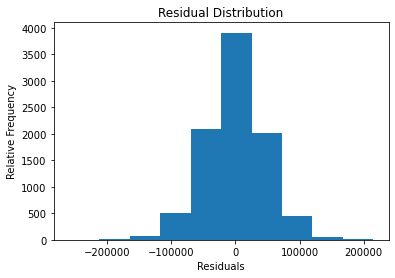

In [18]:
#histogram of residuals from second model
plt.hist(model.resid);
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Relative Frequency');

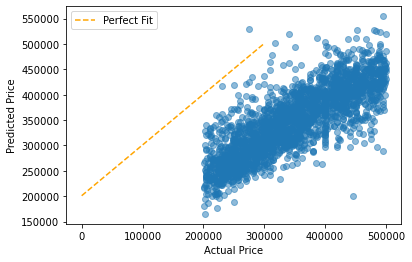

In [19]:
#scatter plot of actual price vs predicted price with a perfect fit line from second model
preds = model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

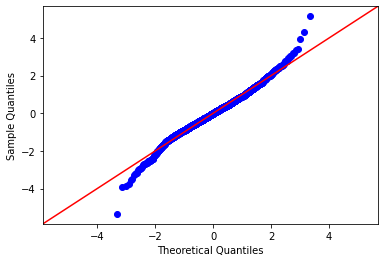

In [20]:
#qqplot for the second model
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Analysis of Residuals
From the residuals histogram,  the residual distribution appears normal.  The qqplot shows a relatively good fit with outliers at either end which was expected from the kurtosis score seen in the OLS model. The rather good fit of the line in the qqplot moreover implies homoskedasticity.<br>

The residuals vs predicted scatter plot looks good although the perfect fit line with the maximum and minimum values of the prices from the test set is above the data points.<br>



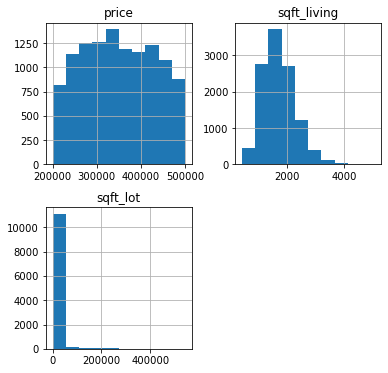

In [21]:
data[['price', 'sqft_living', 'sqft_lot']].hist(figsize=(6,6));

Eliminate the outliers seen in the sqft_lot histogram.

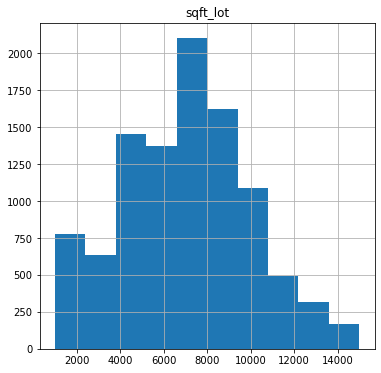

In [22]:
#eliminate outliers in sqft_lot
data = data[(data.sqft_lot > 1000) & (data.sqft_lot < 15000)]

data[['sqft_lot']].hist(figsize=(6,6));

Log transform the sqft_living and sqft_lot predictors in order to have a more "normal" distribution.

In [23]:
data.describe()

,price,sqft_living,sqft_lot,waterfront,has_base,has_renov,bed_2,bed_3,bed_4,bed_5,...,zip_98188,zip_98198,zip_98199,gr_11,gr_4,gr_5,gr_6,gr_7,gr_8,gr_9
count,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,...,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000,10036.000000
mean,348563.592069,1675.353328,7006.839777,0.000100,0.326624,0.020426,0.160422,0.527003,0.256576,0.046333,...,0.009566,0.018633,0.005480,0.000100,0.000399,0.009864,0.135512,0.580909,0.240434,0.030789
std,80978.180982,553.682603,2966.843639,0.009982,0.469002,0.141461,0.367016,0.499295,0.436765,0.210216,...,0.097340,0.135231,0.073829,0.009982,0.019961,0.098834,0.342287,0.493435,0.427369,0.172755
min,200450.000000,390.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280000.000000,1270.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,345000.000000,1610.000000,7210.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,418000.000000,2020.000000,8910.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,499990.000000,5067.000000,14992.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
#calculate std deviation for columns to be standardized for later use in analysis
price_std = np.std(data['price'])

sqft_lot_std = np.std(data['sqft_lot'])

sqft_liv_std = np.std(data['sqft_living'])

In [25]:
print(sqft_liv_std, sqft_lot_std, price_std)

553.655017090306 2966.6958248217593 80974.14649614647


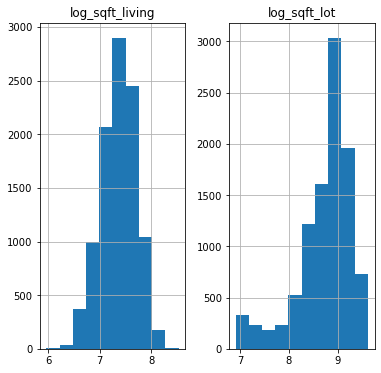

In [26]:
#log transform sqft_living and sqft_lot 
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = np.log(data['sqft_living'])
data_log['log_sqft_lot'] = np.log(data['sqft_lot'])

data_log[['log_sqft_living', 'log_sqft_lot']].hist(figsize=(6,6));

Scale the price, sqft_lot, and sqft_living features through standardization so as to have them on more similar scales as well as to avoid misrepresentation in their coefficients due to their large and variant magnitudes.

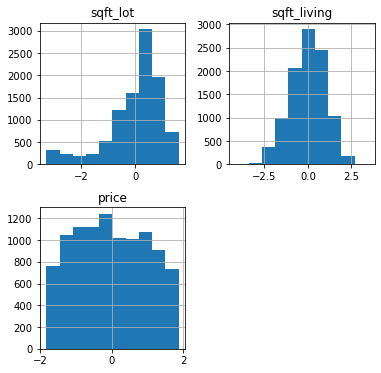

In [27]:
#scale price, sqft_lot and sqftliving_log
price = data['price']
sqft_lot = data_log['log_sqft_lot']
sqft_living = data_log['log_sqft_living']


scaled_price = (price - np.mean(price)) / np.sqrt(np.var(price))
scaled_sqftlot = (sqft_lot - np.mean(sqft_lot) )/ np.sqrt(np.var(sqft_lot))
scaled_sqftliving = (sqft_living - np.mean(sqft_living)) / np.sqrt(np.var(sqft_living))

#df with scaled features only
data_scaled = pd.DataFrame([])
data_scaled['sqft_lot'] = scaled_sqftlot
data_scaled['sqft_living'] = scaled_sqftliving
data_scaled['price'] = scaled_price

data_scaled.hist(figsize=(6,6));

In [28]:
#df to add log and scaled sqft_lot and sqft_living
scaled_df = data.copy()

#drop original price, sqft_lot and sqft_living
scaled_df.drop(['price', 'sqft_lot', 'sqft_living'], axis=1, inplace=True)

#concat log and scaled sqft_lot and sqft_living
scaled_df = pd.concat([scaled_df, data_scaled], axis=1)

### Third regression model: statsmodels and sklearn
#### Numerical features sqft_living and sqft_lot have been log transformed and standardized.  The target,  price, has been standardized as well. 

In [29]:
#model with numerical features transformed and scaled
#train-test split, model with scikit-learn
y = scaled_df.price
X = scaled_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)

y_hat_train = model_linreg.predict(X_train)
y_hat_test = model_linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 8028 rows and 96 columns
y_train is a Series with 8028 values
The training mean squared error:  0.3197030930506553
The test mean squared error:  0.3161551732020035
The training RSME:  0.5654229329012534
The test RSME:  0.562276776331731


In [30]:
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     175.5
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:25:10   Log-Likelihood:                -6813.8
No. Observations:                8028   AIC:                         1.382e+04
Df Residuals:                    7931   BIC:                         1.450e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0434      0.179      0.243      0.808      -0.307       0.394
waterfront               0.5849      0.595      0.983      0.326      -0.581       1.751
has_base                -0.0567      0.018     -3.112      0.002      -0.092      -0.021
has_renov                0.1335      0.046      2.874      0.004       0.042       0.225
bed_2                   -0.0536      0.067     -0.794      0.427      -0.186       0.079
bed_3                   -0.1273      0.068     -1.861      0.063      -0.261       0.007
bed_4                   -0.0733      0.071     -1.033      0.302      -0.212       0.066
bed_5                   -0.1271      0.077     -1.640      0.101      -0.279       0.025
bath_1and_quart_plus     0.0104      0.022      0.476      0.634      -0.032       0.053
bath_2                   0.0256      0.027      0.950      0.342      -0.027       0.078
bath_2and_quart_plus     0.1803      0.029      6.287      0.000       0.124       0.236
bath_3                   0.1498      0.051      2.915      0.004       0.049       0.251
bath_3and_quart_plus     0.2435      0.059      4.119      0.000       0.128       0.359
fl_1and_half            -0.0273      0.028     -0.977      0.328      -0.082       0.027
fl_2                     0.0259      0.025      1.034      0.301      -0.023       0.075
fl_2and_half             0.0622      0.139      0.447      0.655      -0.210       0.335
fl_3                    -0.2722      0.057     -4.816      0.000      -0.383      -0.161
fl_3and_half             0.5463      0.406      1.346      0.178      -0.249       1.342
cond_2                  -0.1383      0.076     -1.818      0.069      -0.287       0.011
cond_4                   0.1077      0.016      6.692      0.000       0.076       0.139
cond_5                   0.2405      0.027      8.816      0.000       0.187       0.294
zip_98002               -0.0426      0.071     -0.603      0.546      -0.181       0.096
zip_98003                0.0664      0.061      1.092      0.275      -0.053       0.186
zip_98004                2.2287      0.576      3.872      0.000       1.100       3.357
zip_98005                2.6027      0.237     10.990      0.000       2.138       3.067
zip_98006                1.9729      0.090     21.960      0.000       1.797       2.149
zip_98007                2.1920      0.104     21.176      0.000       1.989       2.395
zip_98008                2.2562      0.081     27.944      0.000       2.098       2.415
zip_98010                0.2501      0.116      2.151      0.032       0.022       0.478
zip_98011                1.7323      0.076     22.882      0.000       1.584       1.881
zip_98014                1.0119      0.149      6.790      0.000       0.720       1.304
zip_98019                1.1757      0.078     15.004    

### Analysis: third model
The log transformation and standardization to the numerical features resulted in a slightly higher R-squared value of 0.680, an increase of 0.220. The skewness of the model increased slightly indicating the model continues to be negatively skewed. The kurtosis additionally increased moderately despite eliminating outliers in the sqft_lot feature.  These changes additionally transformed the RSME. The large RSME values from the second model were due to the overweighed magnitudes of the numerical features.  The RSME for this model shows the current model to be a good fit.  Furthermore, the train RSME and test RSME are very close, another good indicator. There continue to be insignificant p-values with confidence levels spanning zero although there are now 19. Of note, the p-value of the intercept is unacceptable.

#### Another look at the residuals

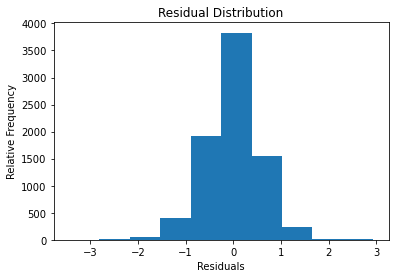

In [31]:
#histogram of residuals from third model
plt.hist(model.resid);
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Relative Frequency');

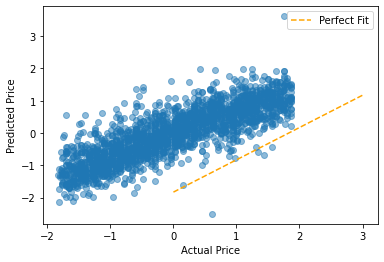

In [32]:
#scatter plot of actual price vs predicted price with a perfect fit line from third model
preds = model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

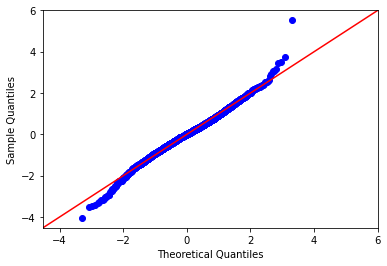

In [33]:
#qqplot for third model 
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

#### Cross validation check

In [34]:
cv_5_results = np.mean(cross_val_score(model_linreg, X, y, cv=5, scoring='neg_mean_squared_error'))
cv_5_results

-6.728469369200969e+21

### Analysis of Residuals and Cross Validation
From the residuals histogram,  the residual distribution continues to appear normal.  Although, in comparison to the previous model, the plot shows a somewhat less normal distribution. The qqplot shows a relatively good fit with outliers at either end which continues to be expected from the kurtosis score. In comparison to the last model, the line is a better fit.<br> 

The residuals vs predicted scatter plot continues to look promising although the perfect fit line changed drastically from the preceding model. Originally it was above the actual/predicted points where currently it is below. At a quick glance at estimated data points on the graphs, the slope appears constant between to the two models.<br> 

The large, negative cross validation MSE indicates a robust model<br>

Transforming and scaling the numerical features resulted in slight improvements to the model. Attention now turns to the p-values obtained through modeling. <br>

Another look at the correltaion matrix

In [35]:
#recheck collinearity as have changed features
#df to look for collinearity in predictors via correlation matrix pairing
data_pred = scaled_df.copy()
data_pred.corr()
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new 
#column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace = True)
#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)
# rename correlation column as cc rather than 0
df.columns = ['cc']
# drop duplicates
df.drop_duplicates(inplace=True)
#list the pairs with a high correlation, indicating collinearity
df[(df.cc > 0.75) & (df.cc < 1)]

,cc
pairs,


No correlation found between any remaining features.

Remove features with maintained insignificant p-values in both the second and third models except for features pertaining to bedrooms or features whose p-values went down significantly between models.

In [36]:
#final dataframe with features dropped according to insignificant p-values
final_df = scaled_df.copy()
final_df.drop(['fl_1and_half', 'fl_2and_half','zip_98003', 'zip_98032', 'zip_98092'], axis=1, inplace=True)

### Fouth regression model: statsmodels and sklearn
#### Removed features with continued insignificant p-values

In [37]:
#model with features that have insignificant p-values removed
#train-test split, model with scikit-learn
y = final_df.price
X = final_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)

y_hat_train = model_linreg.predict(X_train)
y_hat_test = model_linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 8028 rows and 91 columns
y_train is a Series with 8028 values
The training mean squared error:  0.31985598259910974
The test mean squared error:  0.3161654436484037
The training RSME:  0.5655581160226681
The test RSME:  0.5622859091675726


In [38]:
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     185.1
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:25:12   Log-Likelihood:                -6815.7
No. Observations:                8028   AIC:                         1.382e+04
Df Residuals:                    7936   BIC:                         1.446e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0528      0.175      0.301      0.763      -0.291       0.396
waterfront               0.5955      0.595      1.001      0.317      -0.570       1.761
has_base                -0.0542      0.018     -3.076      0.002      -0.089      -0.020
has_renov                0.1329      0.046      2.864      0.004       0.042       0.224
bed_2                   -0.0541      0.067     -0.802      0.422      -0.186       0.078
bed_3                   -0.1303      0.068     -1.906      0.057      -0.264       0.004
bed_4                   -0.0795      0.071     -1.122      0.262      -0.218       0.059
bed_5                   -0.1330      0.077     -1.719      0.086      -0.285       0.019
bath_1and_quart_plus     0.0128      0.022      0.591      0.555      -0.030       0.055
bath_2                   0.0283      0.027      1.053      0.292      -0.024       0.081
bath_2and_quart_plus     0.1842      0.029      6.457      0.000       0.128       0.240
bath_3                   0.1548      0.051      3.020      0.003       0.054       0.255
bath_3and_quart_plus     0.2519      0.058      4.311      0.000       0.137       0.367
fl_2                     0.0275      0.024      1.133      0.257      -0.020       0.075
fl_3                    -0.2682      0.056     -4.814      0.000      -0.377      -0.159
fl_3and_half             0.5502      0.406      1.356      0.175      -0.245       1.346
cond_2                  -0.1388      0.076     -1.825      0.068      -0.288       0.010
cond_4                   0.1072      0.016      6.669      0.000       0.076       0.139
cond_5                   0.2380      0.027      8.742      0.000       0.185       0.291
zip_98002               -0.0556      0.061     -0.915      0.360      -0.175       0.063
zip_98004                2.2181      0.575      3.860      0.000       1.092       3.344
zip_98005                2.5913      0.234     11.075      0.000       2.133       3.050
zip_98006                1.9609      0.082     23.889      0.000       1.800       2.122
zip_98007                2.1802      0.097     22.500      0.000       1.990       2.370
zip_98008                2.2461      0.072     31.167      0.000       2.105       2.387
zip_98010                0.2374      0.111      2.148      0.032       0.021       0.454
zip_98011                1.7199      0.066     25.869      0.000       1.590       1.850
zip_98014                0.9975      0.145      6.902      0.000       0.714       1.281
zip_98019                1.1631      0.070     16.706      0.000       1.027       1.300
zip_98022                0.0413      0.064      0.642      0.521      -0.085       0.167
zip_98023               -0.1143      0.041     -2.799      0.005      -0.194      -0.034
zip_98024                1.1985      0.149      8.018    

#### Cross validation check

In [39]:
cv_5_results = np.mean(cross_val_score(model_linreg, X, y, cv=5, scoring='neg_mean_squared_error'))
cv_5_results

-2.4350869902268433e+22

### Analysis: fourth model

The R-squared value stayed the exact same between models. The skewness and kurtosis remained consistent between models both dropping minutely by a few thousanths. The RSME additionally remained consistent between models with both the train RSME and test RSME increasing minutely by a few ten-thousanths. The mean MSE obtained through cross validation continues to convey that this is a robust model. The p-value of the intercept continues to be insignificant and therefore unacceptable although it dropped by 0.045.

Continue dropping features with continued and unchanging insignificant p-values

In [40]:
final_df.drop(['waterfront', 'bed_5', 'fl_3and_half', 'cond_2', 'gr_11'], axis=1, inplace=True)

### Fifth regression model: statsmodels and sklearn
#### Removed features whose insignificant p-values stayed relatively constant between models

In [41]:
#model with features that have realtively unchanged insignificant p-values removed
#train-test split, model with scikit-learn
y = final_df.price
X = final_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)

y_hat_train = model_linreg.predict(X_train)
y_hat_test = model_linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 8028 rows and 86 columns
y_train is a Series with 8028 values
The training mean squared error:  0.32021937419777685
The test mean squared error:  0.31658643358860816
The training RSME:  0.565879292957232
The test RSME:  0.5626601403943664


In [42]:
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     195.7
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:25:13   Log-Likelihood:                -6820.3
No. Observations:                8028   AIC:                         1.381e+04
Df Residuals:                    7941   BIC:                         1.442e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0615      0.160     -0.385      0.701      -0.375       0.252
has_base                -0.0546      0.018     -3.106      0.002      -0.089      -0.020
has_renov                0.1381      0.046      2.979      0.003       0.047       0.229
bed_2                    0.0456      0.035      1.288      0.198      -0.024       0.115
bed_3                   -0.0232      0.030     -0.771      0.441      -0.082       0.036
bed_4                    0.0313      0.031      1.020      0.308      -0.029       0.091
bath_1and_quart_plus     0.0126      0.022      0.582      0.561      -0.030       0.055
bath_2                   0.0271      0.027      1.009      0.313      -0.026       0.080
bath_2and_quart_plus     0.1851      0.029      6.491      0.000       0.129       0.241
bath_3                   0.1554      0.051      3.042      0.002       0.055       0.256
bath_3and_quart_plus     0.2488      0.058      4.262      0.000       0.134       0.363
fl_2                     0.0266      0.024      1.100      0.272      -0.021       0.074
fl_3                    -0.2763      0.056     -4.974      0.000      -0.385      -0.167
cond_4                   0.1089      0.016      6.793      0.000       0.077       0.140
cond_5                   0.2387      0.027      8.776      0.000       0.185       0.292
zip_98002               -0.0556      0.061     -0.915      0.360      -0.175       0.064
zip_98004                2.0822      0.570      3.654      0.000       0.965       3.199
zip_98005                2.5686      0.234     10.989      0.000       2.110       3.027
zip_98006                1.9604      0.082     23.879      0.000       1.799       2.121
zip_98007                2.1787      0.097     22.482      0.000       1.989       2.369
zip_98008                2.2449      0.072     31.147      0.000       2.104       2.386
zip_98010                0.2399      0.111      2.169      0.030       0.023       0.457
zip_98011                1.7232      0.066     25.918      0.000       1.593       1.853
zip_98014                0.9974      0.145      6.900      0.000       0.714       1.281
zip_98019                1.1672      0.070     16.765      0.000       1.031       1.304
zip_98022                0.0423      0.064      0.659      0.510      -0.084       0.168
zip_98023               -0.1159      0.041     -2.837      0.005      -0.196      -0.036
zip_98024                1.2000      0.150      8.027      0.000       0.907       1.493
zip_98027                1.8945      0.079     23.956      0.000       1.739       2.050
zip_98028                1.4309      0.057     25.296      0.000       1.320       1.542
zip_98029                2.1163      0.074     28.775      0.000       1.972       2.260
zip_98030                0.1352      0.049      2.767    

### Analysis: fifth model

The R squared value decreased very slightly by 0.001. Skewness stayed the same between models and the kurtosis increased a bit by 0.001. The RSME additionally remained consistent between models with both the the train RSME and test RSME increasing minutely by a few ten-thousanths. The p-value of the intercept decreased by 0.062 but continues to remain unacceptable.

Continue dropping features with continued and unchanging insignificant p-values

In [43]:
final_df.drop(['bath_1and_quart_plus', 'zip_98002', 'zip_98022'], axis=1, inplace=True)

### Sixth regression model: statsmodels and sklearn
#### Removed features whose insignificant p-values stayed relatively constant between models

In [44]:
#model with features that have realtively unchanged insignificant p-values removed
#train-test split, model with scikit-learn
y = final_df.price
X = final_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)

y_hat_train = model_linreg.predict(X_train)
y_hat_test = model_linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 8028 rows and 83 columns
y_train is a Series with 8028 values
The training mean squared error:  0.3202926617299212
The test mean squared error:  0.31671352921094803
The training RSME:  0.5659440446986974
The test RSME:  0.562773070794035


In [45]:
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     202.8
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:25:15   Log-Likelihood:                -6821.2
No. Observations:                8028   AIC:                         1.381e+04
Df Residuals:                    7944   BIC:                         1.440e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0581      0.159     -0.365      0.715      -0.370       0.254
has_base                -0.0532      0.017     -3.059      0.002      -0.087      -0.019
has_renov                0.1399      0.046      3.022      0.003       0.049       0.231
bed_2                    0.0451      0.035      1.272      0.203      -0.024       0.114
bed_3                   -0.0223      0.030     -0.744      0.457      -0.081       0.037
bed_4                    0.0313      0.031      1.022      0.307      -0.029       0.091
bath_2                   0.0196      0.023      0.864      0.388      -0.025       0.064
bath_2and_quart_plus     0.1742      0.022      8.095      0.000       0.132       0.216
bath_3                   0.1430      0.047      3.021      0.003       0.050       0.236
bath_3and_quart_plus     0.2373      0.055      4.348      0.000       0.130       0.344
fl_2                     0.0281      0.024      1.167      0.243      -0.019       0.075
fl_3                    -0.2720      0.055     -4.927      0.000      -0.380      -0.164
cond_4                   0.1086      0.016      6.788      0.000       0.077       0.140
cond_5                   0.2404      0.027      8.882      0.000       0.187       0.293
zip_98004                2.0881      0.570      3.665      0.000       0.971       3.205
zip_98005                2.5732      0.233     11.026      0.000       2.116       3.031
zip_98006                1.9634      0.081     24.183      0.000       1.804       2.123
zip_98007                2.1836      0.096     22.731      0.000       1.995       2.372
zip_98008                2.2487      0.071     31.674      0.000       2.109       2.388
zip_98010                0.2433      0.110      2.215      0.027       0.028       0.459
zip_98011                1.7262      0.065     26.379      0.000       1.598       1.854
zip_98014                1.0015      0.144      6.954      0.000       0.719       1.284
zip_98019                1.1700      0.069     17.046      0.000       1.035       1.305
zip_98023               -0.1132      0.039     -2.884      0.004      -0.190      -0.036
zip_98024                1.2023      0.149      8.070      0.000       0.910       1.494
zip_98027                1.8976      0.078     24.283      0.000       1.744       2.051
zip_98028                1.4336      0.055     25.899      0.000       1.325       1.542
zip_98029                2.1190      0.073     29.193      0.000       1.977       2.261
zip_98030                0.1382      0.047      2.910      0.004       0.045       0.231
zip_98031                0.1493      0.047      3.167      0.002       0.057       0.242
zip_98033                2.2860      0.074     30.800      0.000       2.140       2.431
zip_98034                1.8846      0.040     46.820    

### Analysis: sixth model

No significant changes.

Continue dropping features with continued and unchanging insignificant p-values

In [46]:
final_df.drop(['bed_3', 'bed_4', 'fl_2', 'bath_2'], axis=1, inplace=True)

### Final model

#### In previous models, I was avoiding eliminating the bedroom features as it seemed logical that these features would be significant to housing prices.  Their p-values have consistently remained insignificant nor changed enough to suggest that they should persist within the model. In this last model, I keep one bedroom feature (bed_2) and eliminate all other features with unsatisfactory p-values.

In [47]:
#model with features that retained one bedroom feature and removed all other insignificant p-values 
#train-test split, model with scikit-learn
y = final_df.price
X = final_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)

y_hat_train = model_linreg.predict(X_train)
y_hat_test = model_linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 8028 rows and 79 columns
y_train is a Series with 8028 values
The training mean squared error:  0.3207829795462427
The test mean squared error:  0.31609031741371074
The training RSME:  0.5663770648130472
The test RSME:  0.5622191008972487


In [48]:
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     212.7
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:25:16   Log-Likelihood:                -6827.4
No. Observations:                8028   AIC:                         1.381e+04
Df Residuals:                    7948   BIC:                         1.437e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0444      0.156     -0.285      0.776      -0.350       0.261
has_base                -0.0648      0.016     -4.132      0.000      -0.096      -0.034
has_renov                0.1420      0.046      3.073      0.002       0.051       0.233
bed_2                    0.0626      0.021      2.976      0.003       0.021       0.104
bath_2and_quart_plus     0.1821      0.019      9.835      0.000       0.146       0.218
bath_3                   0.1536      0.046      3.347      0.001       0.064       0.243
bath_3and_quart_plus     0.2442      0.053      4.615      0.000       0.141       0.348
fl_3                    -0.3072      0.050     -6.171      0.000      -0.405      -0.210
cond_4                   0.1055      0.016      6.642      0.000       0.074       0.137
cond_5                   0.2403      0.027      8.937      0.000       0.188       0.293
zip_98004                2.1249      0.570      3.729      0.000       1.008       3.242
zip_98005                2.5670      0.233     10.994      0.000       2.109       3.025
zip_98006                1.9639      0.081     24.192      0.000       1.805       2.123
zip_98007                2.1766      0.096     22.669      0.000       1.988       2.365
zip_98008                2.2480      0.071     31.704      0.000       2.109       2.387
zip_98010                0.2374      0.110      2.161      0.031       0.022       0.453
zip_98011                1.7238      0.065     26.333      0.000       1.595       1.852
zip_98014                1.0017      0.144      6.953      0.000       0.719       1.284
zip_98019                1.1680      0.069     17.027      0.000       1.034       1.303
zip_98023               -0.1154      0.039     -2.945      0.003      -0.192      -0.039
zip_98024                1.1937      0.149      8.009      0.000       0.902       1.486
zip_98027                1.8926      0.078     24.214      0.000       1.739       2.046
zip_98028                1.4304      0.055     25.834      0.000       1.322       1.539
zip_98029                2.1101      0.073     29.088      0.000       1.968       2.252
zip_98030                0.1383      0.047      2.911      0.004       0.045       0.231
zip_98031                0.1513      0.047      3.209      0.001       0.059       0.244
zip_98033                2.2811      0.074     30.727      0.000       2.136       2.427
zip_98034                1.8791      0.040     46.793      0.000       1.800       1.958
zip_98038                0.4920      0.037     13.334      0.000       0.420       0.564
zip_98042                0.1635      0.039      4.207      0.000       0.087       0.240
zip_98045                1.1257      0.064     17.523      0.000       1.000       1.252
zip_98052                2.1903      0.061     35.894    

#### Another look at the residuals

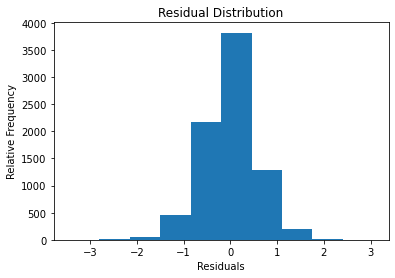

In [49]:
#histogram of residuals from third model
plt.hist(model.resid);
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Relative Frequency');

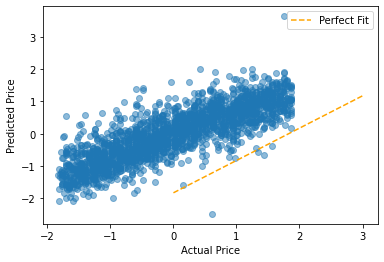

In [50]:
#scatter plot of actual price vs predicted price with a perfect fit line from third model
preds = model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

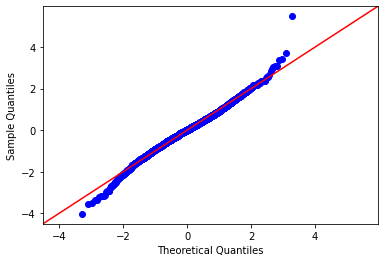

In [51]:
#qqplot for third model 
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

#### Cross validation check

In [52]:
cv_5_results = np.mean(cross_val_score(model_linreg, X, y, cv=5, scoring='neg_mean_squared_error'))
cv_5_results

-9.152760350205028e+17

## Analysis: final model
The R-squared value of 0.679 has been consistent since the fifth model and varied from this in the 3rd and 4th models by a difference of merely 0.001. As R squared measures the strength of the relationship between our model and the target variable, price, this indicates that 67.9% of the variance in the price is explained by the predictor variables collectively.<br><br> All p-values of the remaining predictors are significant and have a value much less than the threshold alpha of 0.05. The intercept's p-value remained insignificant. However, this should not be seen as problematic.  The intercept Beta_0 is the value of the price when all the features are zero which in this case would mean there existed no property i.e. this is a nonsensical case that is far outside the observed data. <br><br> The final skewness evaluated for this model is -0.106 suggesting that the distribution is approximately symmetric and therefore indicative of a normal distribution.<br><br> At 4.429 this model's kurtosis demonstrates a "skinny" leptokurtic distribution, a distribution with longer and fatter tails where the peak is higher and sharper than the peak of a normal distribution. This indicates the distribution has heavy tails and that there are outliers.<br><br> The RSME has remained consistent and acceptable starting with the 3rd model. This demonstrates that the model is a good fit signifying that the observed data points are close to the model's predicted values and therefore this fitted model should predict well.<br><br> All cross validation tests have calculated a large, negative MSE indicating a robust model.<br><br> From the residuals histogram,  the residual distribution continues to appear normalish and meets the normality assumption.  The kurtosis value is reflected in the plot via the slightly skinny peak and longer tails.<br><br>The residuals vs predicted scatter plot continues to look promising although the perfect fit line remains below the data points due to the continued presence of outliers. At a quick glance at estimated data points on the graphs, the slope appears constant between all models.<br><br> The qqplot confirms the homoskedastic assumption as the variance of the residuals is constant or, in other words, the residuals do not vary much as the price changes as seen by the overall good fit of the data points to the line.  


### Coefficients and the Target
The predictors sqft_lot and sqft_living were log transformed, then standardized. The target, price, was standardized. These transformations must be reversed on their respective coefficients in order to assess those predictors affect on price.

In [53]:
#obtain the standardized and log transformed coefficeients of sqft_living and sqft_lot
sqft_liv_coef = model.params[-1]
sqft_lot_coef = model.params[-2]
print(sqft_liv_coef, sqft_lot_coef)

0.41232791419548703 0.10514489629590312


In [54]:
#reverse the standardization of sqft_lot and sqft_living coefficients
unstd_liv_coeff = (sqft_liv_coef * price_std) / sqft_liv_std
unstd_lot_coeff = (sqft_lot_coef * price_std) / sqft_lot_std

In [55]:
#reverse log transform of unstandardized sqft_lot and sqft_living coefficients 
rev_log_liv_coeff = np.exp(unstd_liv_coeff)
rev_log_lot_coeff = np.exp(unstd_lot_coeff)
print(rev_log_lot_coeff, rev_log_liv_coeff)

17.634647603076893 1.548534758442437e+26


In [56]:
#dataframe of the ols regression model
df_model = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [57]:
#get the top ten zipcodes in King County
codes = df_model.iloc[10:72,0]
topten = codes.sort_values(ascending=False).head(10)

#### Inconlusive Feature
When reversing the standardized and log transformed coefficient of the feature sqft_living, the result was implausably large. Future investigation as to whether this feature interacts with other features, such as bedrooms or bathrooms, is required to make a proper assessment of this feature. 

#### Negative Influence on Price
Of the 80 features explored, there were only four predictors that have a negative effect on the home's price.<br>
>   The property having a basement: \\$-0.648 decrease per \\$1 increase in price<br> 
    The property having three floors: \\$-0.3072 decrease per \\$1 increase in price<br>
    The property receiving a grade by the county in the range of 4-9: between \\$-.3985 to \\$-1.6359 decrease per \\$1 increase in price<br>
    The property being situated in the zipcode 98023: \\$-0.1154 decrease per \\$1 increase in price<br>  

#### Positive Influence on Price
The majority of features have a positive on the price of the home. For features that denote the structure of the home itself, the following value increase is observed when all other features are zero:<br>
>  The property having had renovations: \\$0.1420 increase per \\$1 increase in price<br>
   The property having two bedrooms: \\$0.0626 increase per \\$1 increase in price<br>
   The property having multiple bathrooms:<br>
   >>  2.25-2.75 bathrooms: \\$0.1821 increase per \\$1 increase in price<br>
      3 bathrooms: \\$0.1536 increase per \\$1 increase in price<br>
      More than 3 bathrooms: \\$0.2442 increase per \\$1 increase in price<br>
    
When all other features are zero, a one foot increment in the square footage of the lot corresponds to an increase in $17.63 of property value.

Of the 62 zipcodes in the model, all but one of the zipcodes increase home values. This suggests that King County in general is a very desirable county in the area in which to invest in property.  This finding is significant so I focus on the top ten zipcodes for a maximum return on investment. However, I would also note that there are 24 zipcodes whose return on investment factor is at least two.<br>
>  For properties residing in the following zipcodes, the value increase when all other features are zero is:<br>
>  zip_98107: \\$3.0465 increase per \\$1 increase in price   
   zip_98102: \\$2.9990 increase per \\$1 increase in price   
   zip_98105: \\$2.9930 increase per \\$1 increase in price  
   zip_98112: \\$2.8805 increase per \\$1 increase in price  
   zip_98117: \\$2.6987 increase per \\$1 increase in price   
   zip_98199: \\$2.6372 increase per \\$1 increase in price  
   zip_98119: \\$2.6138 increase per \\$1 increase in price   
   zip_98115: \\$2.6004 increase per \\$1 increase in price   
   zip_98005: \\$2.5670 increase per \\$1 increase in price  
   zip_98116: \\$2.5335 increase per \\$1 increase in price  

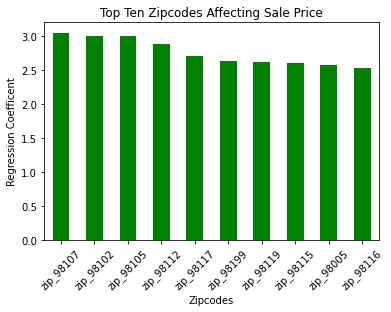

In [58]:
topten.plot.bar(xlabel='Zipcodes', ylabel='Regression Coefficent', 
                title='Top Ten Zipcodes Affecting Sale Price', rot=45, color='green');

## Recommendations
I recommend investors to concentrate on the top ten zipcodes as they offer the maximum rate of return. Whether or not the property has other favorable features associated with it, to have the starting point for the property to be in one of the most desirable locations should guarantee a positive return on their investment. I further advocate for investors to focus on homes with 1-2 levels, a miniumum of 2 bedrooms, and multiple bathrooms. Moreover, purchasing properties with more square footage of the lot will maximize profits. 

## Future Work
Research into why the areas in these zipcodes are so desirable would be wise. Exploring questions like:
>  Are there better schools in these areas?<br>
What is the crime rate in these areas?<br>
Is there an abundance of parks and green space in these areas?<br>
What is the turnover for home sales in these areas?<br>
Do they offer easy access to medical care?<br>
Is a full range of public services offered?<br>
Are they walkable areas?<br>
Are all the essential (grocery stores, etc.) nearby?<br>


Investigating the answers to these questions would be a possible segway to find the next "it" neighborhood in which to invest!!<br>
<br>
To further hone the current model used for this analysis, running another model with any outliers removed and comparing to the current model would be informative.<br>

Lastly, further exploration into whether the feature sqft_living interacts with any other of the features that pertain to the structure of the home would reveal further insights for smart investments. 